In [1]:
import torch 
import torch.nn as nn 
import torch.functional as F
import torch.optim as optim

import numpy as np

import gymnasium

import random 

from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [3]:
from collections import namedtuple , deque
Transition = namedtuple("Transition",["state","action","next_state","reward","done"])

In [4]:
import warnings
warnings.filterwarnings("ignore", message="To copy construct from a tensor")

In [5]:
class ReplayMemory():
    def __init__(self,maxlen : int):
        self.memory = deque(maxlen=maxlen)

    def push(self,x : Transition):
        self.memory.append(x)

    def sample(self,batch_size : int) -> list[Transition]:
        return random.sample(self.memory,batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN,self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2,24),
            nn.ReLU(),

            nn.Linear(24,24),
            nn.ReLU(),

            nn.Linear(24,4),
        )
    
    def forward(self,x):
        return self.network(x)
    
    def save(self,filename : str = None):
        if (filename == None):
            filename = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        torch.save(self.state_dict(),filename)

    def load(self,filename : str):
        self.load_state_dict(torch.load(filename, weights_only=True))

In [7]:
class Env():
    def __init__(self,env_name):
        self.env = gymnasium.make(env_name,render_mode="rgb_array")
        self.state_gym,_ = self.env.reset()
        self.model = DQN()
        self.replay = ReplayMemory(10000)

    def show_state(self):
        img = self.env.render()
        plt.imshow(img)
        plt.axis("off")
        display.clear_output(wait=True)
        plt.show()

    def policy(self):
        prediction = self.model(self.state())
        return torch.max(prediction,0).indices
    
    # To build 
    def state(self) -> torch.tensor:
        if (self.state_gym == None) :
            return torch.tensor([-1,-1],dtype=torch.float)
        y = self.state_gym//12
        x = self.state_gym % 12
        return torch.tensor([x,y],dtype=torch.float)
    
    # To build
    def reset(self):
        self.state_gym,_ = self.env.reset()

     # To build
    def random_action(self) -> torch.tensor:
        gym_action = self.env.action_space.sample()
        return torch.tensor(gym_action)
    
    # 
    def dist(state):
       goal = torch.tensor([11,3],dtype=float)
       if (state[0] == torch.tensor(0) and state[1] == torch.tensor(3)) :
           return torch.tensor(13)
       else :
           return torch.tensor( abs(state[0]-goal[0]) + abs(state[1]-goal[1]))
    # Action : tensor ->  State : tensor , Reward : tensor , Done : bool 
    def step(self,action):
        prev_state = self.state()
        gym_next_state,reward,terminated,truncated,info = self.env.step(int(action))
        self.state_gym = gym_next_state
        done= terminated or truncated or (gym_next_state == 36)
        next_state = self.state()
        r = Env.dist(prev_state) - Env.dist(next_state) 
        if (Env.dist(prev_state) - Env.dist(next_state) >= 0) :
            r = 1
        else :
            r = -2
    
        if (truncated or (gym_next_state == 36)) :
            r -= 100
        if (terminated) :
            r += 100

        self.replay.push(Transition(state=prev_state, action=action, next_state= next_state , reward=torch.tensor(r) , done = done ))

        return next_state, torch.tensor(r) , done

In [8]:
def evaluate(env : Env, try_n : int = 10, maxlen : int = 100):
    s = .0
    for i in range(try_n):
        env.reset()
        for j in range(maxlen):
            obs,r,done = env.step(env.policy())
            s += r.item()
            if (done) : 
                break
    return s/try_n

In [9]:
def play_random(env):
    for i in range(100):
        env.reset()
        while(True):
            state,reward,done = env.step(env.random_action())
            env.show_state()
            if (done):
                break

In [10]:
def play_policy(env):
    for i in range(100):
        env.reset()
        while(True):
            action = env.policy()
            state,reward,done = env.step(env.policy())
            env.show_state()
            if (done):
                break

In [11]:
def optimize(env : Env,optimizer,criterion,batch_size,discount_factor):
    if (len(env.replay) < batch_size) :
        return 
    
    batch = env.replay.sample(batch_size)
    expected = torch.empty((batch_size),dtype=torch.float)
    predicted = torch.empty((batch_size),dtype=torch.float)

    for i in range(batch_size):
        expected[i] = env.model(batch[i].state)[ int(batch[i].action)]
        if (not(batch[i].done)):
            with torch.no_grad() :
                predicted[i] = batch[i].reward + discount_factor * env.model(batch[i].next_state).max()
        else:
            predicted[i] = batch[i].reward

    optimizer.zero_grad()
    loss = criterion(predicted,expected)
    loss.backward()
    torch.nn.utils.clip_grad_value_(env.model.parameters(), 100)
    optimizer.step()



In [12]:
def training(env):
    #env.model.load(filename)
    filename =  "saved_model/"  + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    epochs = 1000
    batch_size = 64

    epsilon = 1
    # epsilon_max = 0.2
    # epsilon_min = 0.05
    # epsilon_decay = 500.0

    epsilon_max = 1
    epsilon_min = 0.05
    epsilon_decay = 300.0

    lr = 1e-4
    discount_factor = 0.9

    optimizer = optim.AdamW(env.model.parameters(), lr=lr, amsgrad=True)
    criterion = nn.MSELoss()

    for i in range(epochs):
        env.reset()
        epsilon = epsilon_min + (epsilon_max-epsilon_min)*np.exp(-i/epsilon_decay)
        while(True):
            if (random.random() <= epsilon ):
                action = env.random_action()
            else :
                with torch.no_grad() :
                    action = env.policy()
            next_state,reward,done = env.step(action)

            optimize(env,optimizer,criterion,batch_size,discount_factor)

            if (done):
                break 
            if (done == False and i % 5 == 0):
                env.show_state()
        if (i%100 == 0) :
             env.model.save(filename)
    env.model.save(filename)

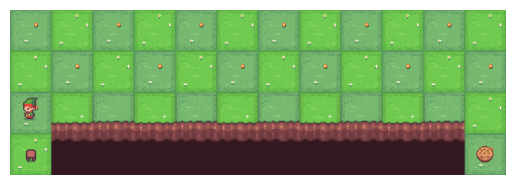

KeyboardInterrupt: 

In [13]:
game_name = "CliffWalking-v0"
env= Env(game_name)
training(env)

In [ ]:
print(evaluate(env))

87.0
